# PSTAT 135 Project

## By Lily Li, Yu Kin Li, Logan Greenough, and Brenda Morales

### Can political party affiliation be predicted based on characteristics of the voter?

In this project we will explore how variables such as education, income, and houshold gender will impact political party affiliation in the state of Georgia. While Georgia is usually considered to be a Republican dominated state, in the most recent presidential race it turned blue and Joe Biden won the electoral votes. We chose Georgia because of how diverse the population is, and because there is a good mix of both rural and urban areas. 

We will start by loading in the data and then doing some exploratory analysis of a few of our predictors to see if there are any clear trends with the predictors. Additionally, we will explore if more variables may be necessary to construct our model beyond just education, income, and household composition.

In [1]:
from pyspark.sql.functions import substring, length, col, expr, sum, desc, mean, lit
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import numpy as np
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
df = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://group21/VM2Uniform--GA--2021-04-16.tab")

<AxesSubplot:xlabel='Parties_Description'>

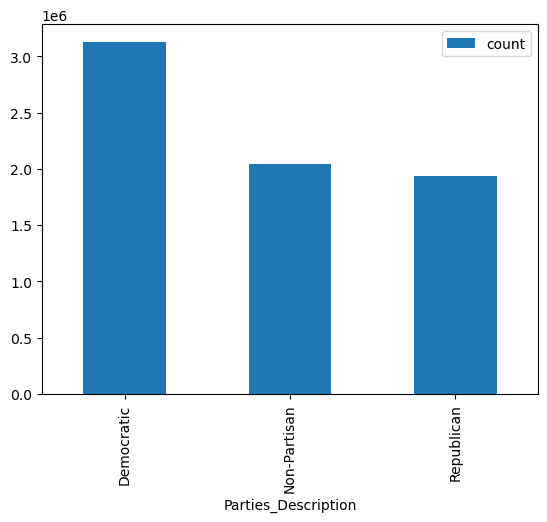

In [3]:
party_df = df.select('Parties_Description').groupby('Parties_Description').count().orderBy(desc("count")).toPandas()
party_df.plot.bar(x='Parties_Description', y='count')

This above graph shows the 3 categories that registered voters fall into: Democratic, Non-Partisan, and Republican. In this instance the Non-Partisan distinction appears to have been given to voters that do not fall into the category of Democrat or Republican. Therefore, it kind of acts as an "Other" category when registered voters do not fall into either of the other 2 groups. For having the perception of being such a red state, it is a bit interesting to see that there are more Democrats than there are Republicans. However, this can be explained by the fact that those that fall into the Non-Partisan category may be "on the fence" voters and can be swayed to vote either way.
Now that we have had a chance to look at the response variable, it's time to explore the input variables and their potential relationship to the response.

## Education

<AxesSubplot:xlabel='CommercialData_Education'>

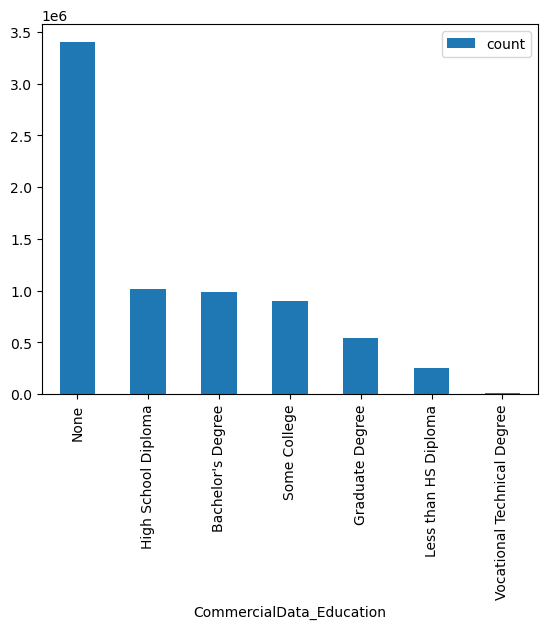

In [4]:
education_df = df.select('CommercialData_Education').replace(['Some College - Likely', 'Some College -Extremely Likely'], 'Some College')
education_df = education_df.select('CommercialData_Education').replace(['Bach Degree - Extremely Likely', 'Bach Degree - Likely'], "Bachelor's Degree")
education_df = education_df.select('CommercialData_Education').replace(['HS Diploma - Likely', 'HS Diploma - Extremely Likely'], "High School Diploma")
education_df = education_df.select('CommercialData_Education').replace(['Grad Degree - Likely', 'Grad Degree - Extremely Likely'], "Graduate Degree")
education_df = education_df.select('CommercialData_Education').replace(['Less than HS Diploma - Likely', 'Less than HS Diploma - Ex Like'], "Less than HS Diploma")
education_df = education_df.select('CommercialData_Education').replace(['Vocational Technical Degree - Extremely Likely'], "Vocational Technical Degree")

education_count_df = education_df.select('CommercialData_Education').groupby('CommercialData_Education').count().orderBy(desc("count")).toPandas()
education_count_df.plot.bar(x='CommercialData_Education', y='count')  

Based on the bar plot above, when it comes to the education level for registered voters there is a large portion that is labeled as "None". This does not mean that the individual did not receive an education, but rather the highest degree of education that they recieved is not known. Because this is such a significant portion of our data set we will keep this information in our data set and not filter it out because these individuals may have provided information to our other input variables.

When it comes to the rest of the graph, we can see that the majority of registered voters in the state of Georgia have a High School Diploma, followed closely by those that have a Bachelor's Degree, and then those that have some college education. It is important to note that this category is of their highest level of education received, which means that it is implied that those that have a Bachelor's Degree also obtained a High School Diploma.

It is also important to note that we had to do a bit of data cleaning since there were multiple rankings for the different types of education. However, we were able to consolidate this data to make it much easier to understand and digest.

<AxesSubplot:xlabel='CommercialData_Education'>

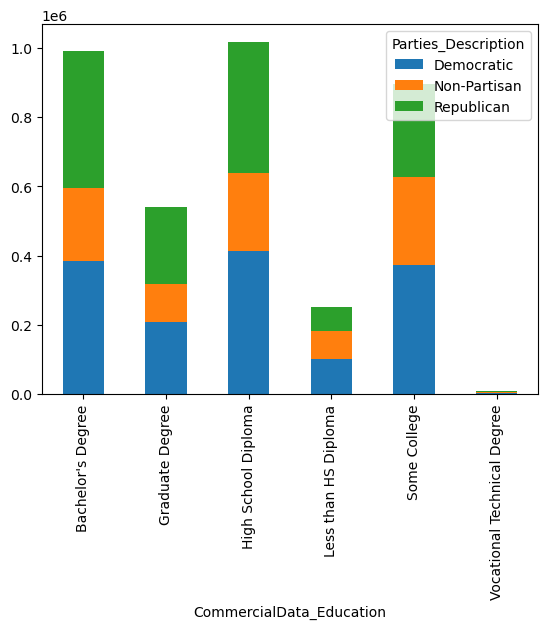

In [5]:
education_party_df = df.select('Parties_Description','CommercialData_Education').toPandas()
education_party_df['CommercialData_Education'] = education_party_df['CommercialData_Education'].replace(['Some College - Likely', 'Some College -Extremely Likely'], 'Some College')
education_party_df['CommercialData_Education'] = education_party_df['CommercialData_Education'].replace(['Bach Degree - Extremely Likely', 'Bach Degree - Likely'], "Bachelor's Degree")
education_party_df['CommercialData_Education'] = education_party_df['CommercialData_Education'].replace(['HS Diploma - Likely', 'HS Diploma - Extremely Likely'], "High School Diploma")
education_party_df['CommercialData_Education'] = education_party_df['CommercialData_Education'].replace(['Grad Degree - Likely', 'Grad Degree - Extremely Likely'], "Graduate Degree")
education_party_df['CommercialData_Education'] = education_party_df['CommercialData_Education'].replace(['Less than HS Diploma - Likely', 'Less than HS Diploma - Ex Like'], "Less than HS Diploma")
education_party_df['CommercialData_Education'] = education_party_df['CommercialData_Education'].replace(['Vocational Technical Degree - Extremely Likely'], "Vocational Technical Degree")
grouped_education_party = education_party_df.groupby(['CommercialData_Education','Parties_Description'])
grouped_education_party.size().unstack().plot(kind='bar', stacked=True)

The above graph is a breakdown of the highest level of education that registered voters recieved and their political affiliation. There are no features that immediately jump out as interesting, as most of the education categories have a breakdown of Democrats and Republicans being about even with Non-Partisan being a smaller portion of the bar. It does appear that for "Less than HS Diploma" and "Some College" they have slightly more Democrats than Republicans, but it is not by an overwhelming majority.

## Estimated Income

<AxesSubplot:xlabel='CommercialData_EstimatedHHIncome'>

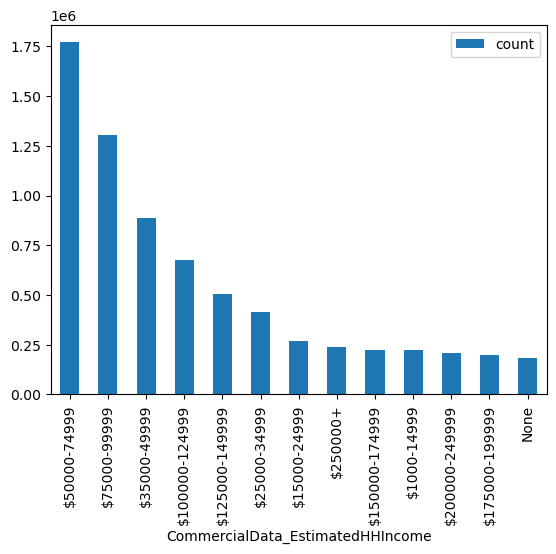

In [6]:
income_df = df.select('CommercialData_EstimatedHHIncome').groupby('CommercialData_EstimatedHHIncome').count().orderBy(desc("count")).toPandas()
income_df.plot.bar(x='CommercialData_EstimatedHHIncome', y='count')  

The above bar chart shows that in the state of Georgia, the most common income range is from \\$50,000 to $74,999. This estimate represents the entire household income for that particular voter, so in a situation where one partner in the household does not work, they would still fall under a certain category based on how much the rest of the household earns. We decided to work with the income range for this portion since it shows the best picture of the income breakdown for the entire state. If we were to use the exact amount of each household, then we would have had to create a continuous graph because of all the unique values, and this would have been a bit messier and harder to interpret.

<AxesSubplot:xlabel='CommercialData_EstimatedHHIncome'>

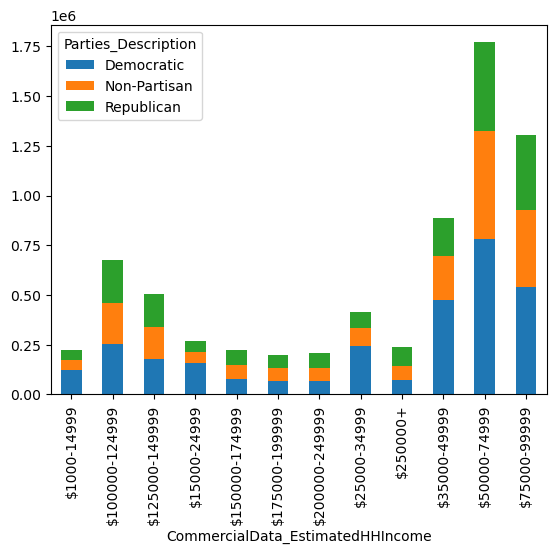

In [7]:
Income_Party = df.select('CommercialData_EstimatedHHIncome','Parties_Description').toPandas()
Income_Party = Income_Party.groupby(['CommercialData_EstimatedHHIncome','Parties_Description'])
Income_Party.size().unstack().plot(kind='bar', stacked=True)

This graph highlights the breakdown of income ranges and the political parties that make up them. It is interesting to see that for the lower ranges of the income levels (\\$1,000-\\$14,999 and \\$15,000-\\$24,999) we see that the majority of the voters are democratic. On the reverse side we see that when it comes to the higher range of income levels (\\$250,000\+) the majority of registered voters are Republican. One possible explanation for this is that those with lower income look to the government for social and economic programs that will help them out, thus making them more left leaning. On the flip side of this, those that earn a higher income want to be taxed less and are then drawn to right leaning policies when it comes to economics.

## Household Composition

<AxesSubplot:xlabel='CommercialData_HHComposition'>

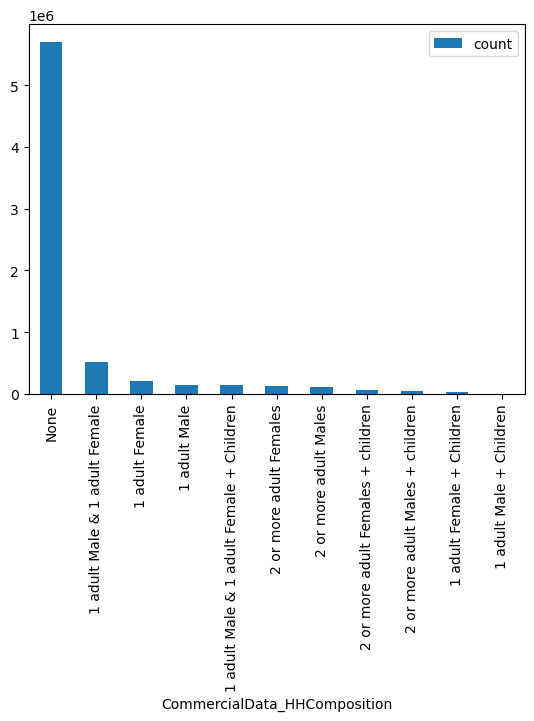

In [8]:
household_df = df.select('CommercialData_HHComposition').groupby('CommercialData_HHComposition').count().orderBy(desc("count")).toPandas()
household_df.plot.bar(x='CommercialData_HHComposition', y='count')  

For most of the registered voters they did not indicate what the composition of their household was, however for those that did the most common was 1 adult male and 1 adult female. This is followed up by 1 adult female living by herself and then 1 adult male living by himself. Once again it will prove to be important to examine the income group for the registered voters without household data, so that we might be able to extrapolate what their living situation might be like.

<AxesSubplot:xlabel='CommercialData_HHComposition'>

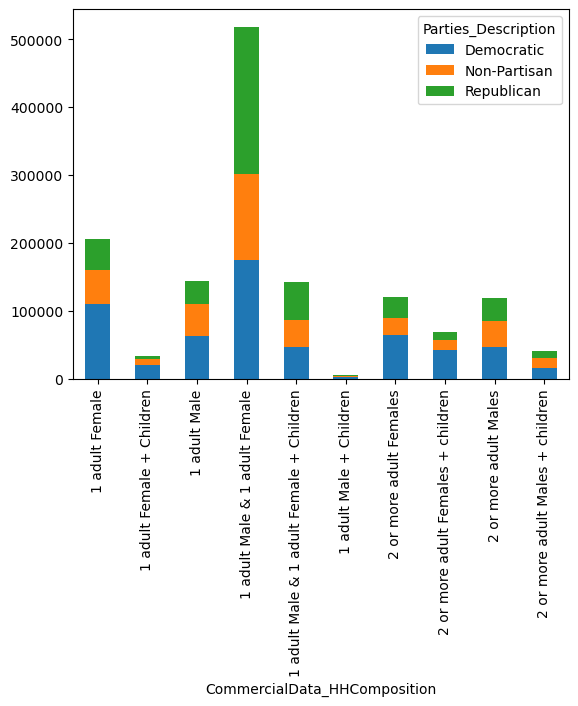

In [9]:
Household_Party = df.select('CommercialData_HHComposition','Parties_Description').toPandas()
Household_Party = Household_Party.groupby(['CommercialData_HHComposition','Parties_Description'])
Household_Party.size().unstack().plot(kind='bar', stacked=True)

This graph is similar to the ones above where the political parties have been overlayed the description of the household for the registered voters. In this graph, the response of "None" has been filtered out, which helps to give a more accurate depiction of the amount of registered voters than make up each option. Those that live alone or live only with children, tend to overwhelmingly be Democrat, while those that live in a household with 1 male and 1 female(without or without children) tend to be Democrat or Republican at about the same ratio.

## Exploring Additional Variables of Interest

### Ethtnic Groups
A voter's ethnic group, religious affliations, primary language, and exact income are additional variables that might influence an individual's choice of political party. Examining these predictors may be beneficial in order to get better insights on these variables and the relations among them as we progress throughout this project.

Let's investigate ethincity first.

There are several ethnic descriptions that have a limited number of observations (some ethnicities even have only a single observations in several cases). So before we continue, let's clean up this dataframe by focusing on only the top 25 ethnicities, which are those that contain more than 5,000 observations and drop any NA's.

Text(0.5, 1.0, 'Distribution of Top 25 Ethnicities')

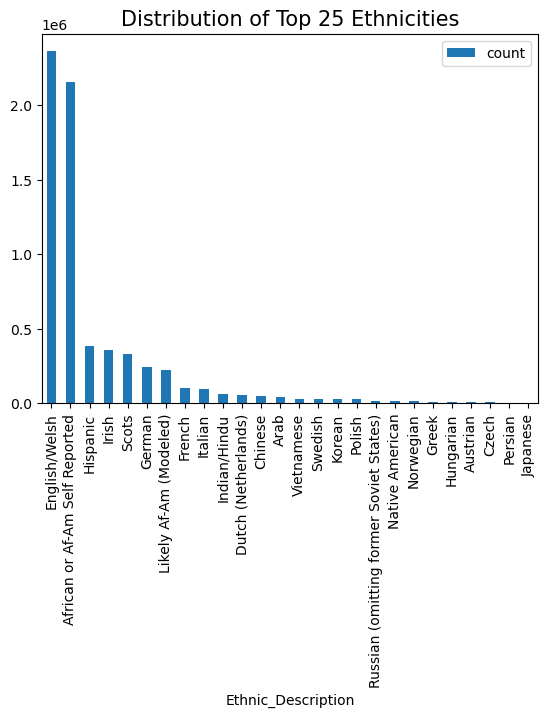

In [10]:
ethnicity_df = df.select('Ethnic_Description').groupby('Ethnic_Description').count().orderBy(desc("count")).toPandas()

# top 25: ethnic descriptions with over 5,000 observations
top25 = ethnicity_df.where(ethnicity_df['count'] > 5000).dropna()
top25.plot.bar(x='Ethnic_Description', y='count')
plt.rcParams['figure.figsize'] = (25, 8)
plt.xticks(fontsize = 10)
plt.title('Distribution of Top 25 Ethnicities', fontsize=15)

This is how the different ethnicities are spread. Over 2 million reported English/Welsh and African or African-American. After these two ethnicities, we see a sharp drop for the remaining ethnicities. These are followed by Hispanic, Irish, and Scotish ethnicities, with a litle over 300,000 observations. 

Now, continue and let's take a look at how this can be dissected by political party.

Text(0.5, 1.0, 'Top 25 Ethnicities by Political Party')

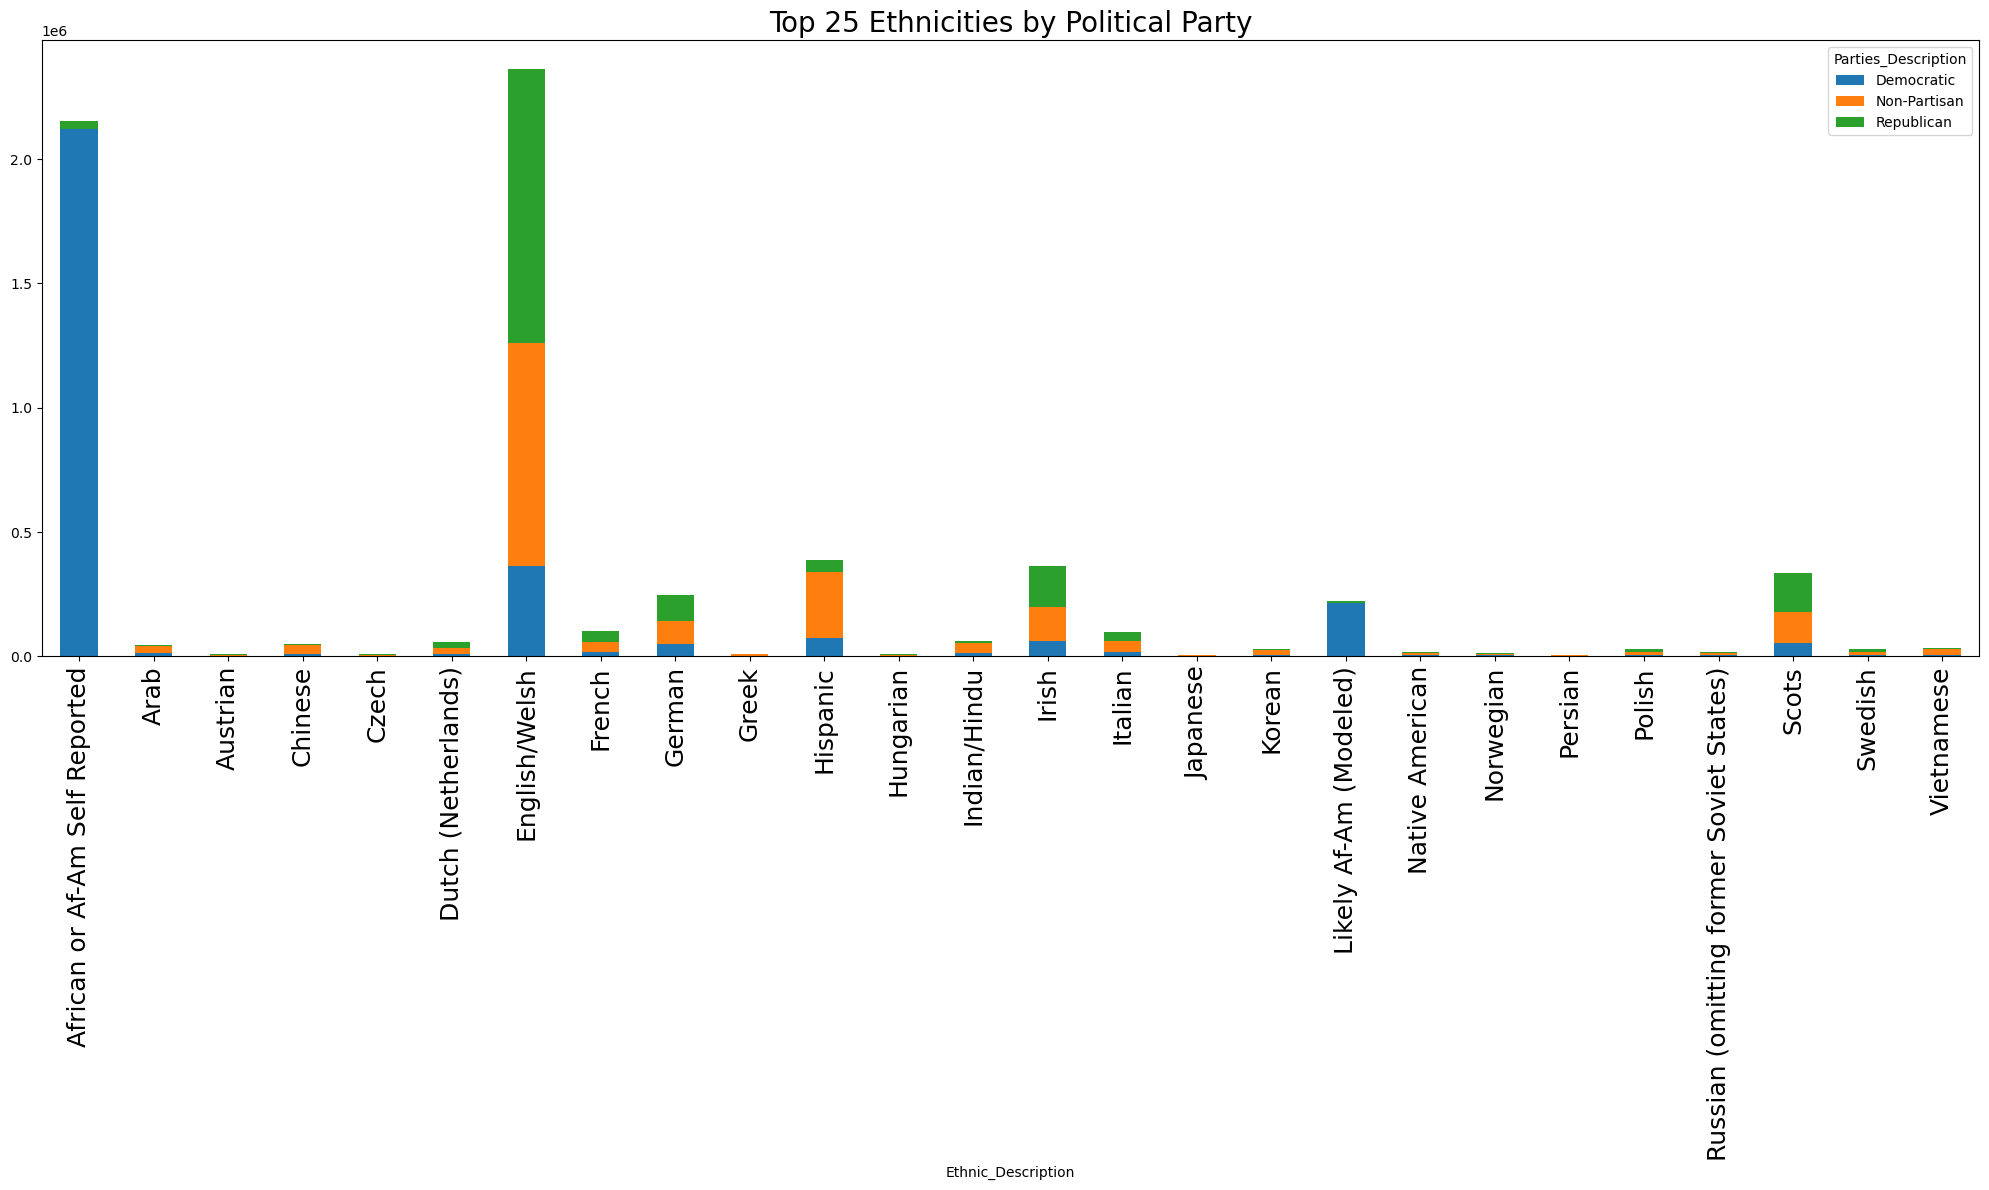

In [11]:
top25list = ['English/Welsh', 'African or Af-Am Self Reported', 'Hispanic', 'Irish', 'Scots', 'German',
             'Likely Af-Am (Modeled)', 'French', 'Italian', 'Indian/Hindu', 'Dutch (Netherlands)', 'Chinese', 
             'Arab', 'Vietnamese', 'Swedish', 'Korean', 'Polish', 'Russian (omitting former Soviet States)',
             'Native American', 'Norwegian', 'Greek', 'Hungarian', 'Austrian', 'Czech', 'Persian', 'Japanese']

# create df with ethnicities and party decriptions
ethnicity_by_party = df.select('Ethnic_Description','Parties_Description').toPandas()
ethnicity_by_party = ethnicity_by_party.where(ethnicity_by_party['Ethnic_Description'].isin(top25list)).dropna()
ethnicity_by_party = ethnicity_by_party.groupby(['Ethnic_Description','Parties_Description'])

# bar graph by political party
ethnicity_by_party.size().unstack().plot(kind='bar', stacked=True)
plt.rcParams['figure.figsize'] = (25, 25)
plt.xticks(fontsize = 18)
plt.title('Top 25 Ethnicities by Political Party', fontsize=20)

The top reported ethnicties include: English/Welsh, African or African-American, Hispanic, Irish, ad Scotish. It is apparent that the majority of voters who reported African or African American ethnicity were almost entirely from the Democratic party. This finding is also true for Likely African-American (Modeled) ethnic category. Republican voters take the lead in reporting the highest counts of English/Welsh ethnicity, the Hipanic Ethnicity group is mainly made up on Non-Partisan voters, and Republican and Non-Partisan voters dominate the Irish and Scotish ethnicities.

Now that we have a better understanding of how the ethnicities are distributed by political party, let's move on to see how these ethnic descriptons can be further categorized to the main **Ethnic Groups**.

Text(0.5, 1.0, 'Ethnic Groups by Party')

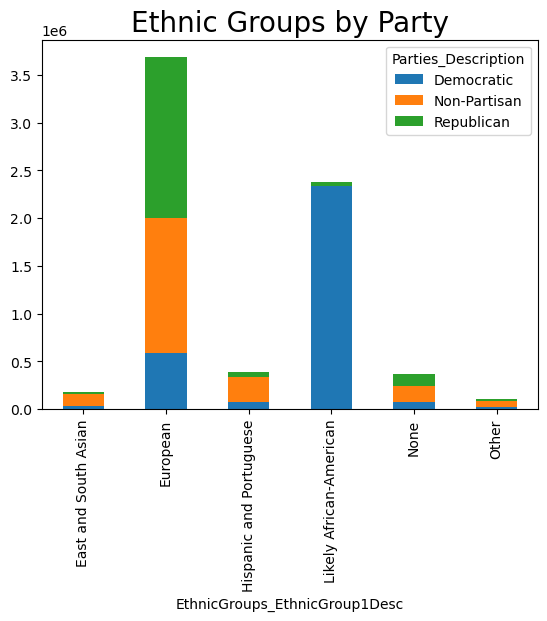

In [ ]:
ethnicity= df.select('Parties_Description', 'Ethnic_Description', 'EthnicGroups_EthnicGroup1Desc').fillna("None").toPandas()
ethnicity_grouped = ethnicity.groupby(['EthnicGroups_EthnicGroup1Desc','Parties_Description'])
ethnicity_grouped.size().unstack().plot(kind='bar', stacked=True)
plt.title('Ethnic Groups by Party', fontsize=20)

Just like in the `Ethnic_Description` plot, this plot of the ethnic groups shows that the majority of Hispanics are Non-Partisans and the majority of African Americans are Democracts. Interesntly enough, the European group has almost equal amounts of Republican and Non-Partisan voters.

### Religion
Another interesting variable to look into is a voter's religious affiliations. 

Georgia is one of the ten states in the *Bible Belt*, an area in the southern region of the United States where Protestant Christianity plays a strong role in their every day life, society, and politics. States in the *Bible Belt*, tend to hold more conservative views compared to the rest of the United States, which may impact a voter's choice of political party.

Let's see if this holds true in the state of Georgia.

In [3]:
religion= df.select('Religions_Description','Parties_Description').toPandas()
religion['Religions_Description'] = religion['Religions_Description'].fillna('None')

# in order to split to two seperate plots
top_reported_religions1 = ['Protestant', 'Jewish', 'Catholic']
top_reported_religions2 = ['Buddhist', 'Eastern Orthodox', 'Christian', 'Hindu']

In [4]:
# for plot 1
religion= df.select('Religions_Description','Parties_Description').toPandas()
religion['Religions_Description'] = religion['Religions_Description'].fillna('None')
religion = religion.where(religion['Religions_Description'].isin(top_reported_religions1)).dropna()
religion = religion.groupby(['Religions_Description','Parties_Description'])

# for plot 2
religion2= df.select('Religions_Description','Parties_Description').toPandas()
religion2['Religions_Description'] = religion2['Religions_Description'].fillna('None')
religion2 = religion2.where(religion2['Religions_Description'].isin(top_reported_religions2)).dropna()
religion2 = religion2.groupby(['Religions_Description','Parties_Description'])

<AxesSubplot:xlabel='Religions_Description'>

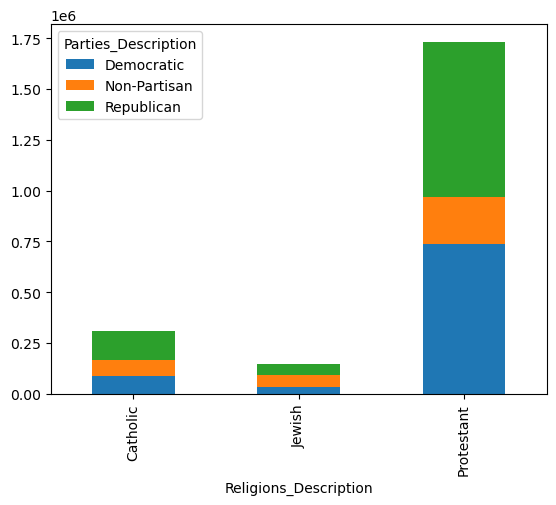

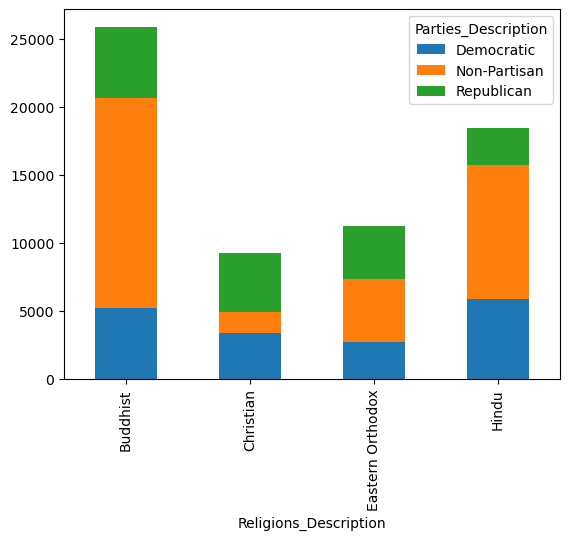

In [5]:
religion.size().unstack().plot(kind='bar', stacked=True)
religion2.size().unstack().plot(kind='bar', stacked=True)

Unfortunately, many of the values in the `Relgions_Description` column were missing/not reported. These values were filled with "None" and were not included in the final visualization above. However, honing in on the restricted religious data we are left with, we can still draw out new trends.

The bar plot above of the voters religious affiliation by political party was split into two plots because even though the Buddhist, Hindu, Eastern Orthodox, and Christian religions were among the top religious reported, the number of observations for these religions were significantly lower compared to the top three religions (i.e. Protestant, Jewish and Catholic). This was done to scale the plot according to the amount of observations we were dealing with.

From the first plot, we can see that Protestant is the leading religion in Georgia, followed by Catholicism and Jewish religions. Breaking it down by political party tells us that Protestant was the dominant religion in Georgia. An interesting observation from the first plot is that are nearly even amounts of Democrats and Republicans who reported being Protestant. Again, this was expected considering the religious prevelance in the south. 

### Language

<AxesSubplot:xlabel='Languages_Description'>

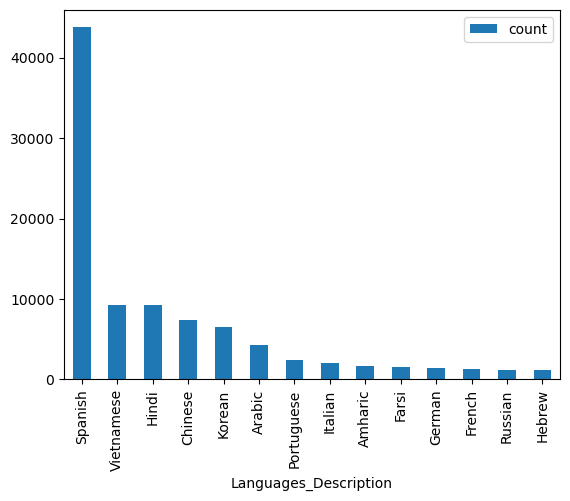

In [6]:
languages_df = df.select('Languages_Description').groupby('Languages_Description').count().orderBy(desc("count")).toPandas()

# to plot top langaues WITHOUT English, for a better scaled graph
topLanguages = languages_df.where((languages_df['count'] > 1000) & (languages_df['count'] != 2893503.0)).dropna()
topLanguages.plot.bar(x='Languages_Description', y='count')

The plot above shows how the voter's primary language is distributed. Top languages in Georgia include: Spanish, Vietnamese, Hindi, Chinese, and Korean.

English is by far the most widely used language in the United States, so we can expect this to remain true in Georgia. We intentionally removed English for this exact reason. There were nearly 3 million observations where English was the primary language of the voter. This was a drastically larger number than the rest of the reported languages (i.e. Spanish only has about 44,000, Vietnamese and Hindi only had about 9,000 observation, etc...). Thus, we will analyze English seperately.

<AxesSubplot:xlabel='Languages_Description'>

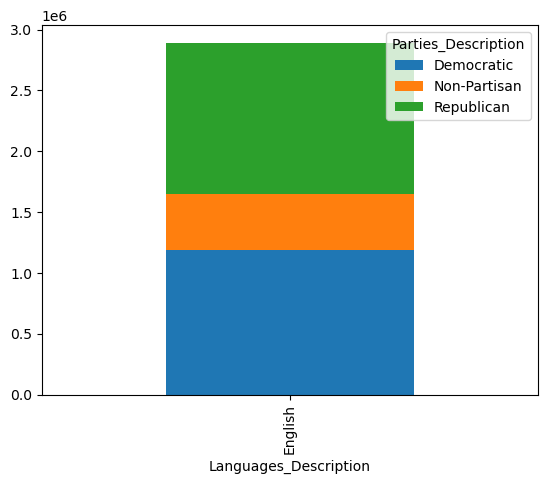

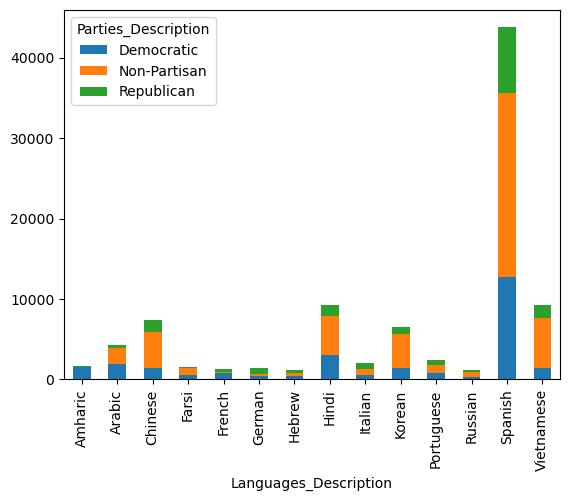

In [7]:
top14languages = ['Spanish', 'Vietnamese', 'Hindi', 'Chinese', 'Korean', 'Chinese', 
                 'Korean', 'Arabic', 'Portuguese', 'Italian', 'Amharic', 'Farsi', 
                  'German', 'French', 'Russian','Hebrew']

# language by political party (English only)
english_only= df.select('Languages_Description','Parties_Description').toPandas()
english_only['Languages_Description'] = english_only['Languages_Description'].fillna('None')
english_only = english_only.where(english_only['Languages_Description'] == 'English').dropna()
english_only = english_only.groupby(['Languages_Description','Parties_Description'])

# languages by political party (excluding English)
languages= df.select('Languages_Description','Parties_Description').toPandas()
languages['Languages_Description'] = languages['Languages_Description'].fillna('None')
languages = languages.where(languages['Languages_Description'].isin(top14languages)).dropna()
languages = languages.groupby(['Languages_Description','Parties_Description'])

english_only.size().unstack().plot(kind='bar', stacked=True)
languages.size().unstack().plot(kind='bar', stacked=True)

The political affiliation of voters as well as their primary language are shown above. The first plot that shows the data specifically for English language. No particular traits of this graph stand out as noteworthy as the ratio of Republican and Democrats are about the same while Non-Partisans make up a smaller section of the bar. Comparing Non-Partisans to the other political parties, it appears that they make up a little larger fraction of the bar for several of remaining languages. 

## Profiles by Political Affiliation
Shifting gears, let's take a look at distributions of income and household makeup amongst polital parties.

In [9]:
# Create DF with exact income (variable exactIncome) from CommercialData_EstimatedHHIncomeAmount
exactIncome_df = df.filter(df.CommercialData_EstimatedHHIncomeAmount.isNotNull()).select('CommercialData_EstimatedHHIncomeAmount','Parties_Description', 
                           'Voters_Gender', 'CommercialData_EstimatedHHIncome'
                          ).withColumn("exactIncome",expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast('integer')).drop('CommercialData_EstimatedHHIncomeAmount')

In [ ]:
# DEMOCRAT ANALYSIS
# Average Income of all Democrats is 78,447.58
exactIncome_democrat = exactIncome_df.where(exactIncome_df.Parties_Description == 'Democratic')
summed_democrat = exactIncome_democrat.agg({'exactIncome': 'sum'}).select('sum(exactIncome)').collect()[0][0] # 238296063075
avg_income_democrat = summed_democrat / exactIncome_democrat.count() 

# Average Income of Female Democrat is 77,139.90
F_Income_democrat = exactIncome_df.where((exactIncome_df.Parties_Description == 'Democratic') & (exactIncome_df.Voters_Gender == 'F'))
F_summed_democrat = F_Income_democrat.agg({'exactIncome': 'sum'}).select('sum(exactIncome)').collect()[0][0] 
avg_F_democrat = F_summed_democrat / F_Income_democrat.count()

# Average Income of Male Democrat is 80,124.80
M_Income_democrat = exactIncome_df.where((exactIncome_df.Parties_Description == 'Democratic') & (exactIncome_df.Voters_Gender == 'M'))
M_summed_democrat = M_Income_democrat.agg({'exactIncome': 'sum'}).select('sum(exactIncome)').collect()[0][0] 
avg_M_democrat = M_summed_democrat / M_Income_democrat.count() 

# REPUBLICAN ANALYSIS
# Average Income of all Republicans is 98,425.97
exactIncome_republican = exactIncome_df.where(exactIncome_df.Parties_Description == 'Republican')
summed_republican = exactIncome_republican.agg({'exactIncome': 'sum'}).select('sum(exactIncome)').collect()[0][0] 
avg_income_republican = summed_republican / exactIncome_republican.count()

# Average Income of Female Republican is 96,658.62
F_Income_republican = exactIncome_df.where((exactIncome_df.Parties_Description == 'Republican') & (exactIncome_df.Voters_Gender == 'F'))
F_summed_republican = F_Income_republican.agg({'exactIncome': 'sum'}).select('sum(exactIncome)').collect()[0][0] 
avg_F_republican = F_summed_republican / F_Income_republican.count()

# Average Income of Male Republican is 100,315.66
M_Income_republican = exactIncome_df.where((exactIncome_df.Parties_Description == 'Republican') & (exactIncome_df.Voters_Gender == 'M'))
M_summed_republican = M_Income_republican.agg({'exactIncome': 'sum'}).select('sum(exactIncome)').collect()[0][0] 
avg_M_republican = M_summed_republican / M_Income_republican.count()

### Here's a likely income profile of a voter registered as a Democrat:

Income Analysis
Average Income of all Democrats: $78,447

    Average Income of Female Democrats: $77,139
    
    Average Income of Male Democrats: $80,124
    
25.7% of Democrats have income in \\$50,000-\\$74,999 group

### Here's a likely income profile of a voter registered as a Republican:

Income Analysis
Average Income of all Republicans: $98,425

    Average Income of Female Republican: $96,658
    
    Average Income of Male Republican: $100,315
    
22.9 % of republicans have income in \\$50,000-\\$74,999 group

The average republican makes $19,978 more than the average democrat.



### Exact Income by Political Party
It is apparent that Republican have the highest average income values than Democrats and Non-Partisan. Yet, for all of the poltical parties’, including Non-Partisan, the largest slice is the \\$50,000−\\$74,999 income group. This tells us that there are more Republicans on higher scale, which misrepresents the averages. In order to get a better perspective on the range and concentration of the distribtuion of the `exactIncome` data, let's create a few final graphs to help us visualize this. 

First, we'll plot the distribution of exact income by parties. Then we'll construct a box-plot visually illustrate the five number summary of the exact income data by political affilication.

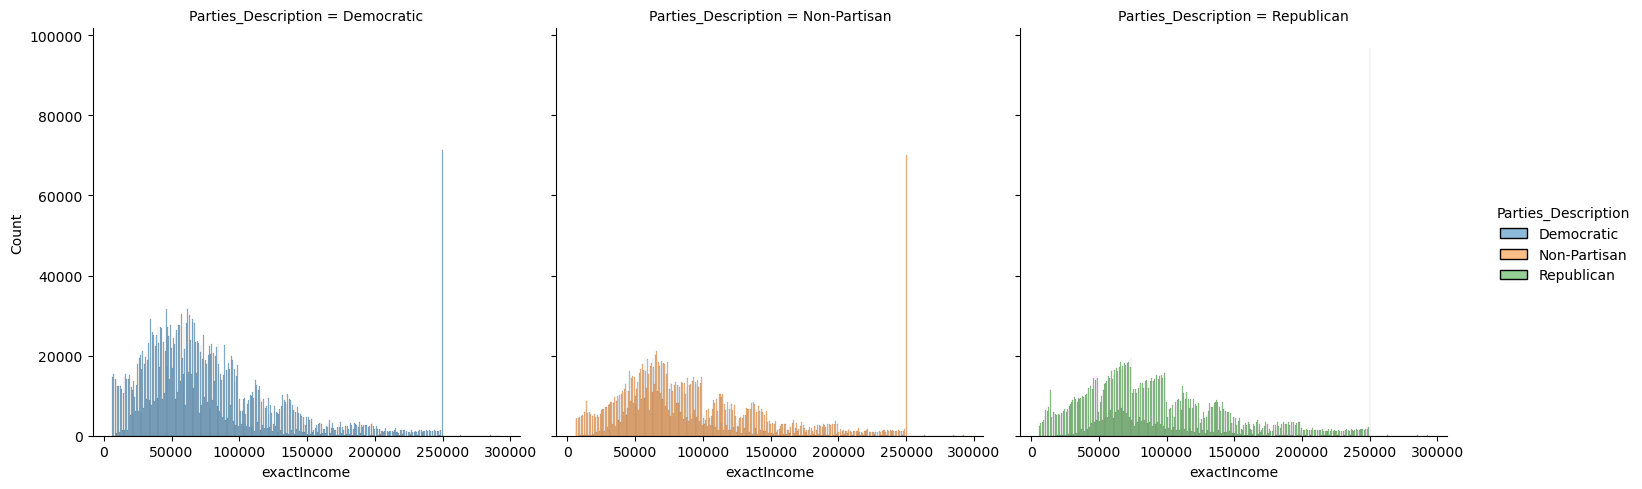

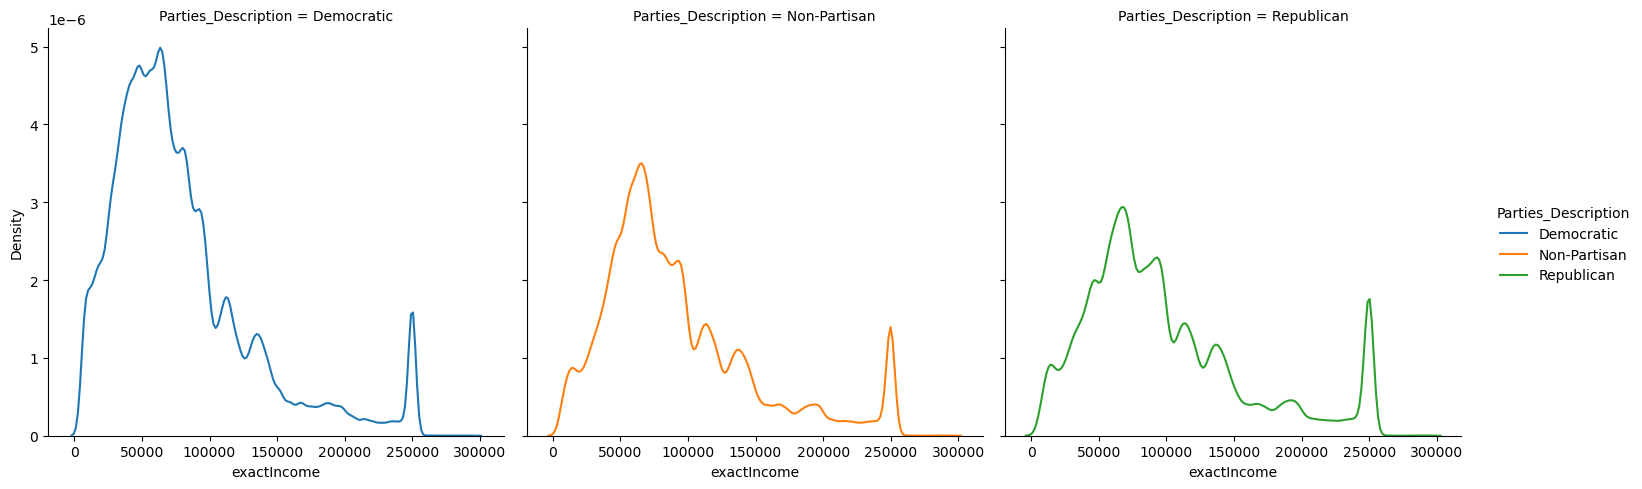

In [10]:
# to pandas df
exactIncome_pd = exactIncome_df.toPandas()

#figure 1
sns.displot(data=exactIncome_pd, x="exactIncome", 
            hue = "Parties_Description",col="Parties_Description", 
            kde = False)

#figure 2
sns.displot(data=exactIncome_pd, 
            x="exactIncome", hue = "Parties_Description", 
            col="Parties_Description", 
            kind="kde")

The first illustration is a basic histogram that displays the counts of the exact income by political party. The second is a kernal density plot, which smoothes out noise by using kernel smoothing over a continuous range, resulting in smoother distributions. This makes it easier to visually understand and see the differences by party. 

Based on the two graphs above, we can decipher that the exact income data is right skewed, meaning most of the `exactIncome` values are in the fifty-thousand to seventy-five thousand range. All three parties, however, show a considerable jump around the \\$250,000 mark--especially for the Republican party. Hence, the mean value exact income is easily afffected by extreme values for all parties, though this is especially true for the Republican party. 

Let's see how this translates on a box-plot.

[Text(0.5, 0, 'Exact Income'), Text(0, 0.5, 'Political Party')]

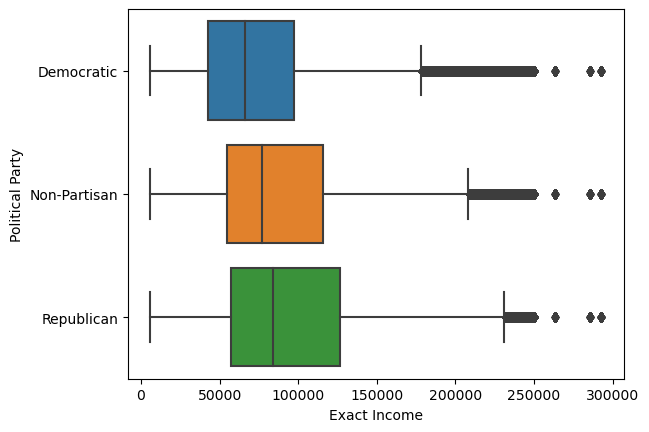

In [11]:
sns.boxplot(x='exactIncome', y='Parties_Description', data=exactIncome_pd).set(
    xlabel='Exact Income',
    ylabel='Political Party')

As expected, the box plot displays that the Republican party has the largerst range comepared to the Democratic and Non-partisan parties. Thus, confirming our belief that there are more Republicans on the high extreme.

### Highest Household Proportion

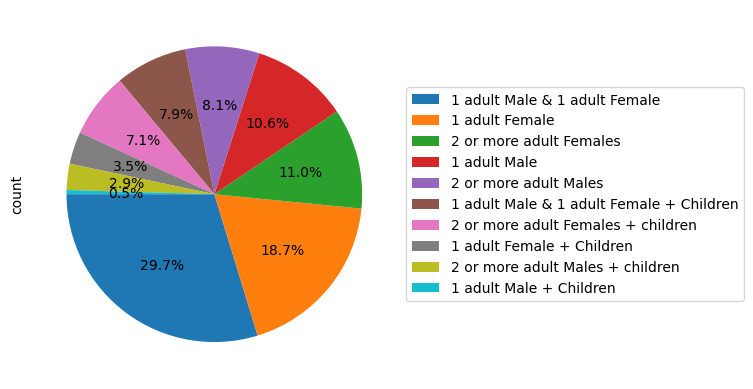

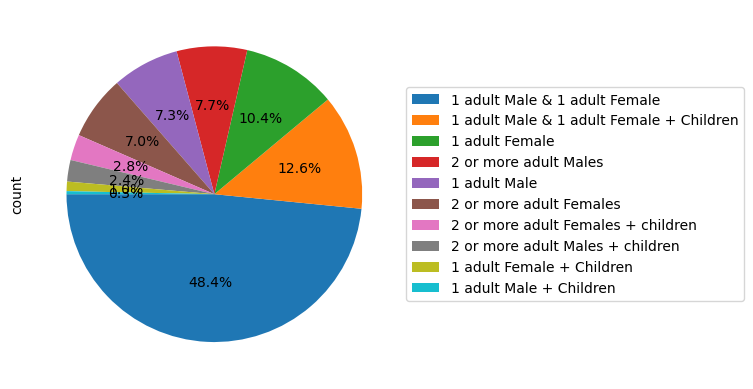

In [12]:
household_democrat = df.filter(df.CommercialData_HHComposition.isNotNull()).where(df.Parties_Description == 'Democratic').select('CommercialData_HHComposition').groupby('CommercialData_HHComposition').count().orderBy(desc("count")).toPandas()
household_democrat.plot.pie(y='count', labels=None, startangle=180, autopct='%1.1f%%').legend(household_democrat['CommercialData_HHComposition'], loc='center left', bbox_to_anchor=(1.0, 0.5))

household_republican = df.filter(df.CommercialData_HHComposition.isNotNull()).where(df.Parties_Description == 'Republican').select('CommercialData_HHComposition').groupby('CommercialData_HHComposition').count().orderBy(desc("count")).toPandas()
household_republican.plot.pie(y='count', labels=None, startangle=180, autopct='%1.1f%%').legend(household_republican['CommercialData_HHComposition'], loc='center left', bbox_to_anchor=(1.0, 0.5))

### Here's a likely household profile of a voter registered as a Democrat:
When the household information is filled (not null), 29.7% of democrats live in 1 adult Male and 1 adult Female household, so most likely heterosexual couple. Following that, it is interesting to note female only households (18.7% 1 adult Female and 11% 2+ adult Females).

### Here's a likely household profile of a voter registered as a Republican:
When the household information is filled (not null), 48.4% of republicans live in 1 adult Male and 1 adult Female household. After that, 12.6% are 1 adult Male and 1 adult Female + children.

Here we can see that if a voter is Republican, then they are more likely to live in 1 adult Male and 1 adult Female household compared to Democrats. 

# Model Making 

Since it will prove to be difficult to make a meaningful prediction of a voters' political party soley based on education, income, and household composition, we will expand to a few other predictors indicated below. With all of the predictors below we will move to the model building stage, and then analyze the results of our models.

#### Our Dependent Variable:
Dependant Variable | Description
---|---
Parties_Description | Voters political affiliation (Republican, Non-Partisan, Democratic)

#### Our Predictors:
Predictor | Variable Description
---|---
CommericalData_Education | Level of education (less than a HS Diploma - Graduate Degree)
CommericalData_EstimatedHHIncome | Grouped range of income  
CommericalData_EstimatedHHIncomeAmount| Exact income amount
CommericalData_HHComposition| Gender makeup amount of children in household
EthnicGroups_EthnicGroup1Desc| Ethnicity of voter
Religious_Description| Religious affiliation of voter
Languages_Description | Primary language spoken by voter
Voters_Gender | Gender of voter (male or female)

### Preparing the Data

* Grouping education regardless of likelihood
* Converting estimated income to an integer

In [40]:
new_df = df.filter(df.CommercialData_EstimatedHHIncomeAmount.isNotNull()) # we don't want to assign 0's nulls in an integer column that would affect our averages
new_df = new_df.limit(10000).select('Parties_Description',
                                'CommercialData_Education',
                               'CommercialData_EstimatedHHIncome',
                                'CommercialData_EstimatedHHIncomeAmount',
                               'CommercialData_HHComposition',
                               'EthnicGroups_EthnicGroup1Desc',
                               'Religions_Description',
                               'Languages_Description',
                               'Voters_Gender')
new_df = new_df.replace(
    ['Some College - Likely', 'Some College -Extremely Likely'], 'Some College', subset='CommercialData_Education').replace(
    ['Bach Degree - Extremely Likely', 'Bach Degree - Likely'], "Bachelor's Degree", subset='CommercialData_Education').replace(
    ['HS Diploma - Likely', 'HS Diploma - Extremely Likely'], "High School Diploma", subset='CommercialData_Education').replace(
    ['Grad Degree - Likely', 'Grad Degree - Extremely Likely'], "Graduate Degree", subset='CommercialData_Education').replace(
    ['Less than HS Diploma - Likely', 'Less than HS Diploma - Ex Like'], "Less than HS Diploma", subset='CommercialData_Education').replace(
    ['Vocational Technical Degree - Extremely Likely'], "Vocational Technical Degree", subset='CommercialData_Education').withColumn(
    "exactIncome",expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast('integer')).drop(
    'CommercialData_EstimatedHHIncomeAmount')

new_df = new_df.fillna('None')
new_df.cache() # caching to reduce time retreiving data when fitting model

23/03/22 03:51:27 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


DataFrame[Parties_Description: string, CommercialData_Education: string, CommercialData_EstimatedHHIncome: string, CommercialData_HHComposition: string, EthnicGroups_EthnicGroup1Desc: string, Religions_Description: string, Languages_Description: string, Voters_Gender: string, exactIncome: int]

### Creating a Logistic Regression Model for Multiclass Predictions

In [41]:
supervised = RFormula(formula="Parties_Description ~ .")

fittedRF = supervised.fit(new_df)

preparedDF = fittedRF.transform(new_df)

### Define the feature column

In [42]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')

### Splitting & fitting the data to the training set

In [43]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 9)
lr = LogisticRegression(labelCol="label",featuresCol="features")

lrModel = lr.fit(train)

### Using the coefficient matrix, identify the most significant predictors for classes

Classes
* 0.0 Republican
* 1.0 Non-Partisan
* 2.0 Democratic

In [44]:
coefsArray = lrModel.coefficientMatrix.toArray()  # convert to np.array
labeled_classes = pd.DataFrame({'Republican': coefsArray[0],
              'Non-Partisan': coefsArray[1],
             'Democratic': coefsArray[2]})
labeled_classes.index = list(featureCols['name'])

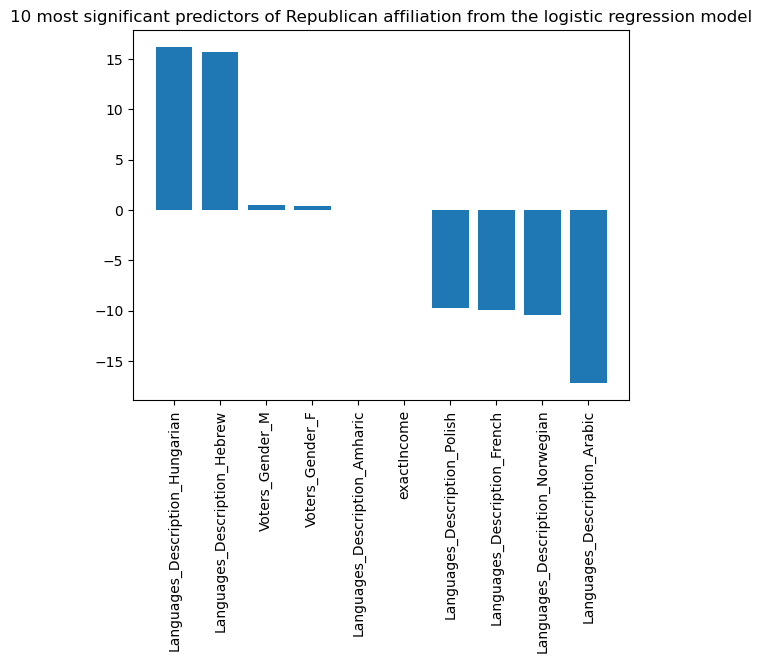

In [45]:
rep_features = labeled_classes.iloc[labeled_classes['Republican'].abs().sort_values(ascending=False).argsort()[0:10]].sort_values('Republican', ascending=False)
plt.xticks(rotation=90)
plt.bar(rep_features.index, rep_features.Republican)
plt.title('10 most significant predictors of Republican affiliation from the logistic regression model')
plt.show()

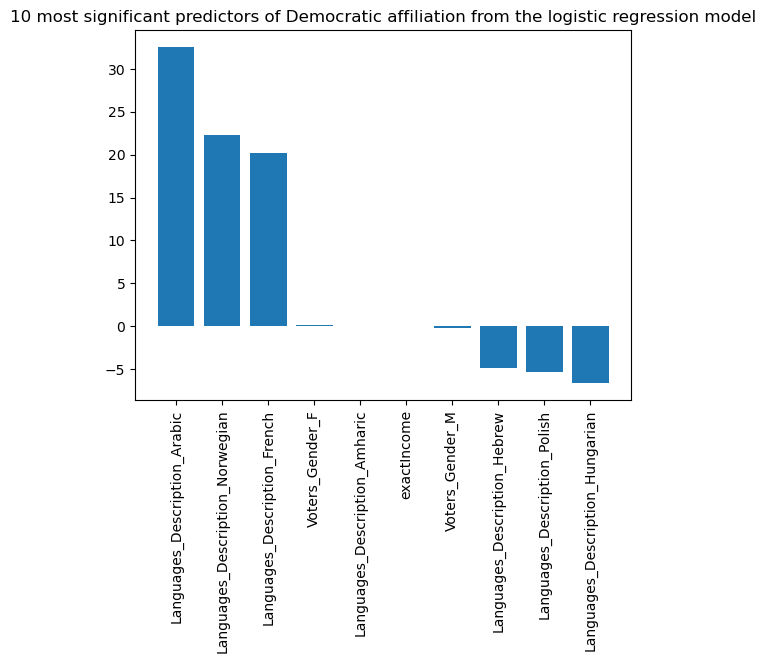

In [46]:
dem_features = labeled_classes.iloc[labeled_classes['Democratic'].abs().sort_values(ascending=False).argsort()[0:10]].sort_values('Democratic', ascending=False)
plt.xticks(rotation=90)
plt.bar(dem_features.index, dem_features.Democratic)
plt.title('10 most significant predictors of Democratic affiliation from the logistic regression model')
plt.show()

## Evaluating Model Performance

Now that we have constructed our model it is time to evaluate how it did with the training data. 

In [47]:
eval = MulticlassClassificationEvaluator(labelCol = "label")
auc = eval.evaluate(lrModel.summary.predictions)
print(auc) # AUC for training set = 0.6626443767791348

0.6626443767791348


In [48]:
MulticlassClassificationEvaluator(labelCol="label", 
                                predictionCol="prediction", 
                                  metricName="accuracy").evaluate(lrModel.summary.predictions)
# 0.7260430015662822

0.6656699416203902

In [49]:
lrModel.summary.truePositiveRateByLabel

[0.6833126550868487, 0.7132352941176471, 0.4188351920693928]

In [50]:
lrModel.summary.falsePositiveRateByLabel

[0.29955251381942616, 0.2949640287769784, 0.0033783783783783786]

In [51]:
lrModel.summary.precisionByLabel

[0.6593834181382819, 0.6421907914535059, 0.9415041782729805]

Based on the ouptutted values above we can see that using our logistic regression model with the training data we get an AUC value of 0.6626443767791348, which is okay based on the fact that we want this number to be as close to 1 as we can get it. Other values that we extracted from the model were the true positive rate by label, false positive by label, and precision by label, which are as follows:

True Positive
* Republican: 0.6833126550868487
* Non-Partisan: 0.7132352941176471
* Democratic: 0.4188351920693928

False Positive
* Republican: 0.29955251381942616
* Non-Partisan: 0.2949640287769784
* Democratic: 0.0033783783783783786

Precision
* Republican: 0.6593834181382819
* Non-Partisan: 0.6421907914535059
* Democratic: 0.9415041782729805

The true positive rate is the percentage of predictions for our desired outcome(ex: deciding a voter is a Republican) that are correct(i.e. the voter IS a Republican). 

The false positive rate is the percentage of predictions for our desired outcome(ex: deciding a voter is a Republican) that are incorrect(i.e. the voter IS NOT a Republican). 

The precision is calculated by using the formula TP/(TP+FP), meaning that it is the proportion of correct predictions over the total number of predictions it made for the desired outcome(i.e. correct Republican predictions over all Republican predictions).

Based on these values for each of our classes we can come to the conclusion that our model is fairly accurate when it comes to correctly picking the correct class with the training data. This is espcially clear when it comes to the model picking Democrats, because it has the highest precision. To further analyze the performance of this model we will try the testing data.

### Using the Testing Data

Now that we have analyzed how the model performed with the training data it is time to use the testing data to fully evaluate the model.

In [52]:
lrModel_test = lr.fit(test)

In [53]:
eval = MulticlassClassificationEvaluator(labelCol = "label")
auc_test = eval.evaluate(lrModel_test.summary.predictions)
print(auc_test) # AUC ROC for testing set = 0.6862064494295663

0.6862064494295663


In [55]:
MulticlassClassificationEvaluator(labelCol="label", 
                                predictionCol="prediction", 
                                  metricName="accuracy").evaluate(lrModel_test.summary.predictions)

0.6886126973463218

In [56]:
lrModel_test.summary.truePositiveRateByLabel

[0.7255474452554744, 0.710795902285264, 0.4556213017751479]

In [57]:
lrModel_test.summary.falsePositiveRateByLabel

[0.2937149968886123, 0.2605386416861827, 0.0037893141341417205]

In [58]:
lrModel_test.summary.precisionByLabel

[0.6780354706684857, 0.6696362286562731, 0.9390243902439024]

Based on the ouptutted values above we can see that using our logistic regression model with the testing data we get an AUC value of 0.6862064494295663, which is 0.02 higher than the AUC with the training data. Other values that we extracted from the model were the true positive rate by label and false positive by label, which are as follows:

True Positive
* Republican: 0.7255474452554744
* Non-Partisan: 0.710795902285264
* Democratic: 0.4556213017751479

False Positive
* Republican: 0.2937149968886123
* Non-Partisan: 0.2605386416861827
* Democratic: 0.0037893141341417205

Precision
* Republican: 0.6780354706684857
* Non-Partisan: 0.6696362286562731
* Democratic: 0.9390243902439024

Utilizing the testing data we can conclude that this model is somewhat accurate when it comes to predicting the political party of a voter. Similar to the analysis of the testing data the model is fairly good at predicting a voter that is a Democrat, as evidence by the precision and false positive rate. It is worth noting that there is still a portion of voters that are Democrats that the model is not predicting correctly. The biggest area that this model struggles in is when it comes to predicting Non-Partisan voters. This is seen by the low precision value, as well as the low true positive rate. To see if we can achieve better results we will isolate each of the classes and utilize a binary model.

## One Vs. Rest Model

Now that we have created a multiclass logistic regression model, we will isolate the data and try a binary approach to see how the model performs. In order to do this we will create three additional models where the voters' party will be "Republican" or "Not Republican", "Democrat" or "Not Democrat", and "Non-Partisan" or "Not Non-Partisan". After these models have been constructed we will analyze the models and then fit them with the testing data to further evaluate model performance.

In [59]:
train_rep = new_df.replace(['Non-Partisan', 'Democratic'], 'Not Republican', subset='Parties_Description')

rep_fitted = supervised.fit(train_rep)

rep_preparedDF = rep_fitted.transform(train_rep)

rep_train, rep_test = rep_preparedDF.randomSplit([0.7, 0.3], seed = 9)

repModel = lr.fit(rep_train)

rep_roc = repModel.summary.roc.toPandas()

repModel.summary.areaUnderROC # Republican vs Rest = 0.7579966681841968

0.7579966681841968

In [60]:
train_dem = new_df.replace(['Non-Partisan', 'Republican'], 'Not Democratic', subset='Parties_Description')

dem_fitted = supervised.fit(train_dem)

dem_preparedDF = dem_fitted.transform(train_dem)

dem_train, dem_test = dem_preparedDF.randomSplit([0.7, 0.3], seed = 9)

demModel = lr.fit(dem_train)

dem_roc = demModel.summary.roc.toPandas()

demModel.summary.areaUnderROC # Democratic vs Rest = 0.7948403129629893

0.7948403129629893

In [61]:
train_np = new_df.replace(['Democratic', 'Republican'], 'Not Non-Partisan', subset='Parties_Description')

np_fitted = supervised.fit(train_np)

np_preparedDF = np_fitted.transform(train_np)

np_train, np_test = np_preparedDF.randomSplit([0.7, 0.3], seed = 9)

npModel = lr.fit(np_train)

np_roc = npModel.summary.roc.toPandas()

npModel.summary.areaUnderROC # Non-Partisan vs Rest = 0.7748813408299557

0.7748813408299557

Text(0, 0.5, 'TPR')

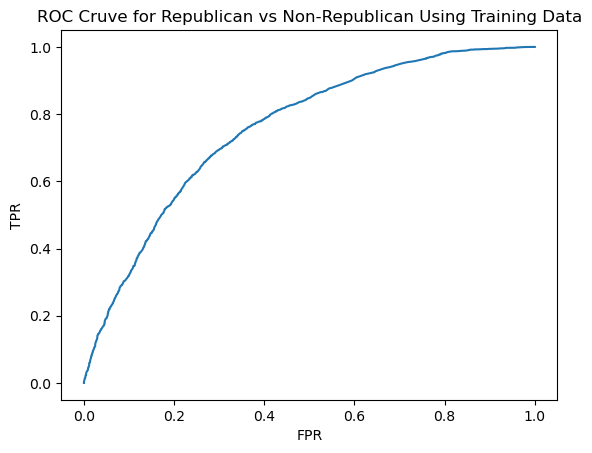

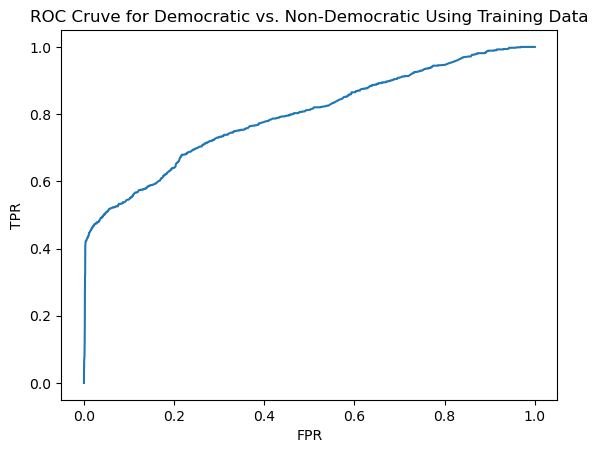

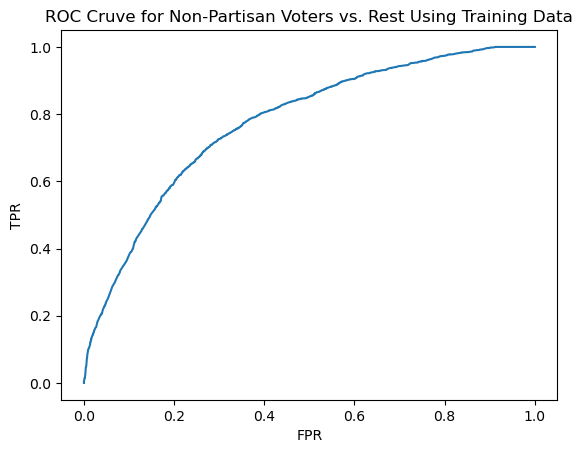

In [62]:
rep_roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve for Republican vs Non-Republican Using Training Data')
plt.ylabel('TPR')

dem_roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve for Democratic vs. Non-Democratic Using Training Data')
plt.ylabel('TPR')

np_roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve for Non-Partisan Voters vs. Rest Using Training Data')
plt.ylabel('TPR')

Using the training data with each of the binary models, we can see that the Democrat vs Non-Democrat model returned the best AUC ROC value of 0.7948403129629893, followed by the Non-Partisan vs Rest with an AUC ROC of 0.7748813408299557, and lastly followed by Republican vs Non-Republican model returning and AUC ROC of 0.7579966681841968. Using these values with the graphs above we can say that with the testing data our model is best at classifying Democrats. 

### Using the Testing Data

Now that we have analyzed how the model performed with the training data it is time to use the testing data to fully evaluate the model.

In [63]:
repModel_test = lr.fit(rep_test)

rep_roc_test = repModel_test.summary.roc.toPandas()

repModel_test.summary.areaUnderROC # Republican vs Rest = 0.763783901634728

0.763783901634728

In [64]:
demModel_test = lr.fit(dem_test)

dem_roc_test = demModel_test.summary.roc.toPandas()

demModel_test.summary.areaUnderROC # Democratic vs Rest = 0.8164677089896444

0.8164677089896444

In [65]:
npModel_test = lr.fit(np_test)

np_roc_test = npModel_test.summary.roc.toPandas()

npModel_test.summary.areaUnderROC # Non-Partisan vs Rest = 0.7738993658533883

0.7738993658533883

Text(0, 0.5, 'TPR')

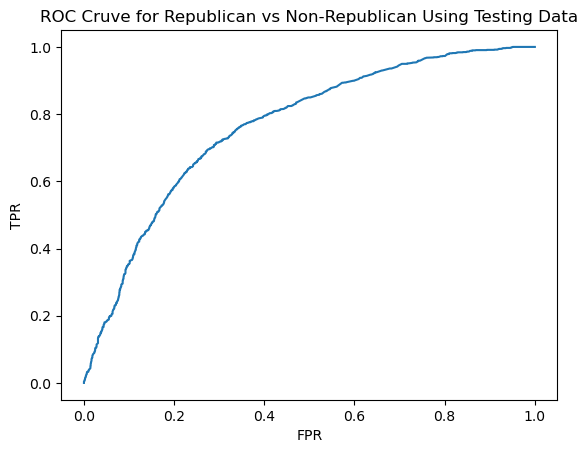

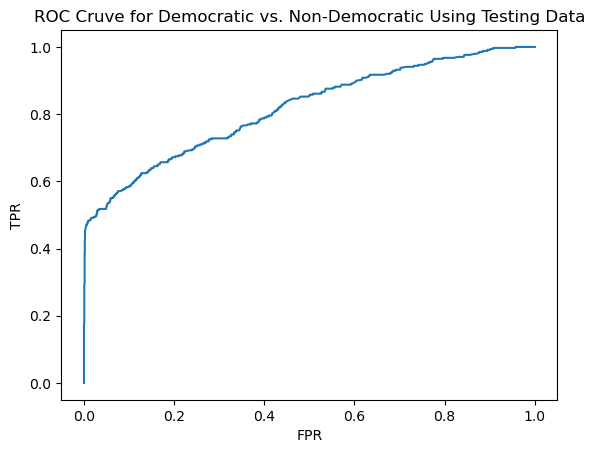

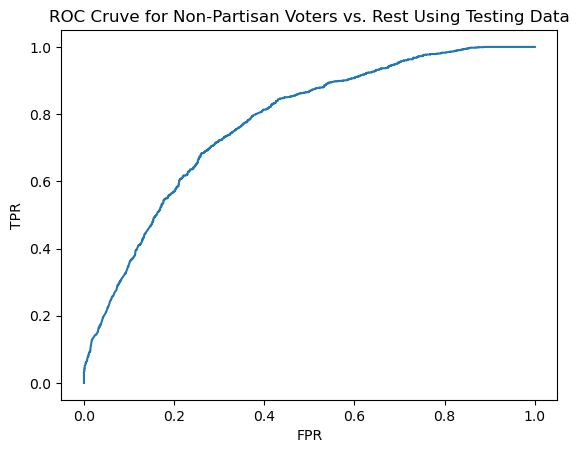

In [66]:
rep_roc_test.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve for Republican vs Non-Republican Using Testing Data')
plt.ylabel('TPR')

dem_roc_test.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve for Democratic vs. Non-Democratic Using Testing Data')
plt.ylabel('TPR')

np_roc_test.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve for Non-Partisan Voters vs. Rest Using Testing Data')
plt.ylabel('TPR')

Using the testing data with each of the binary models, we can see that the Democrat vs Non-Democrat model returned the best AUC ROC value of 0.8164677089896444, followed by Non-Partisan vs Rest with an AUC ROC of 0.7738993658533883, and lastly followed by the Republican vs Non-Republican model returning and AUC ROC of 0.763783901634728. Therefore it can be said that when it comes to predicting a voters' political party, the binary model is the best at predicting whether or not a voter is a Democrat. This can be attributed to patterns found in the predictors that we selected for our dataset. It is worth noting that in the training data the ROC AUC was slightly higher for the Non-Partisan vs Rest, however with the testing data we see that the Republican vs Non-Republican is slightly better. Overall, our binary models performed well with the testing data, which is evidenced by the fact that the all of the AUC ROC's for the models are higher with the training data.

## LASSO Regression

The last model that we will use to try and predict a voters' party affiliation using a LASSO regression model. 


Using multinomial linear regression, LASSO will shrink predictors that have minimal effect on the outcome down to zero. Removing insignificant variables using penalties based on lambda values will reduce random patterns from our model.


In [67]:
logreg = LogisticRegression(featuresCol = "features", 
                 labelCol = 'label', standardization = True, elasticNetParam = 1)

In [68]:
paramGrid_logreg = ParamGridBuilder().addGrid(logreg.regParam, np.linspace(0.0, 1, 10) * 0.1).build()

We'll be using cross validation with 5 folds.

In [69]:
crossval_logreg = CrossValidator(estimator = logreg, 
                                 estimatorParamMaps = paramGrid_logreg, 
                                 evaluator = MulticlassClassificationEvaluator(), 
                                 numFolds = 5) 

In [ ]:
cvModel_logreg = crossval_logreg.fit(train)

Below are the average area under the curve values for the ten smoothing values and the best is 0.656813373323268. The best penalty term is log(0.01) = -2. However, utilizing LASSO regularization and cross-validation didn't seem to drastically improve the ROC AUC and accuracy when comparing to without a penalty term (lambda = 0).

In [71]:
cvModel_logreg.avgMetrics

[0.656813373323268,
 0.6536098005304113,
 0.6480215921209407,
 0.6469114245846924,
 0.6463851971420909,
 0.6463851971420909,
 0.6463851971420909,
 0.6463851971420909,
 0.6463851971420909,
 0.6463851971420909]

In [72]:
predictions = cvModel_logreg.transform(test)
predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   97|
|  2.0|       1.0|   88|
|  2.0|       2.0|  153|
|  1.0|       0.0|  362|
|  1.0|       1.0|  907|
|  0.0|       0.0|  945|
|  0.0|       1.0|  417|
|  0.0|       2.0|    8|
+-----+----------+-----+



In [73]:
log_lambda = [0]
log_lambda.extend(list(np.log10(list(np.linspace(0.0, 1, 10) * 0.1)[1:10])))

Text(0, 0.5, 'AUC ROC')

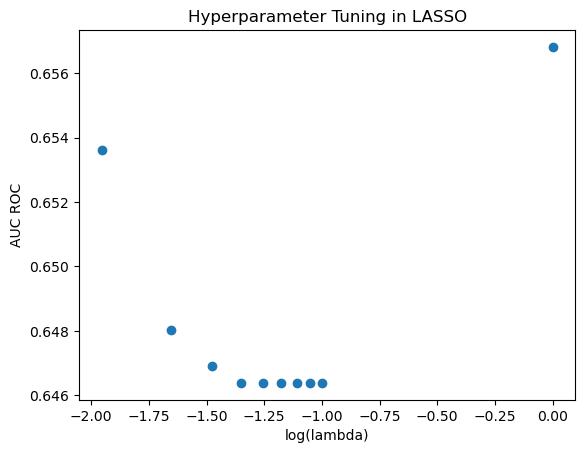

In [74]:
plt.scatter(log_lambda, cvModel_logreg.avgMetrics)
plt.title('Hyperparameter Tuning in LASSO')
plt.xlabel('log(lambda)')
plt.ylabel('AUC ROC')

In [75]:
import math
math.log(0.022222222222222223)
# log(0.022222222222222223) value -3.8066624897703196 with best auc roc 0.656813373323268

-3.8066624897703196

Now we can evaluate the accuracy as another metric.

In [76]:
crossval_logreg_acc = CrossValidator(estimator = logreg, 
                                 estimatorParamMaps = paramGrid_logreg, 
                                 evaluator = MulticlassClassificationEvaluator( metricName="accuracy"), 
                                 numFolds = 5) 

In [ ]:
cvModel_logreg_acc = crossval_logreg_acc.fit(train)

In [ ]:
cvModel_logreg_acc.avgMetrics 

[0.6599622848697175,
 0.6571148089364013,
 0.6518478634123714,
 0.6505674822040057,
 0.6499957032325788,
 0.6499957032325788,
 0.6499957032325788,
 0.6499957032325788,
 0.6499957032325788,
 0.6499957032325788]

We get similar accuracies across different lambda values. The best lambda value doesn't have an accuracy that different from accuracy without a penalty term (lambda = 0).

Text(0, 0.5, 'Accuracy')

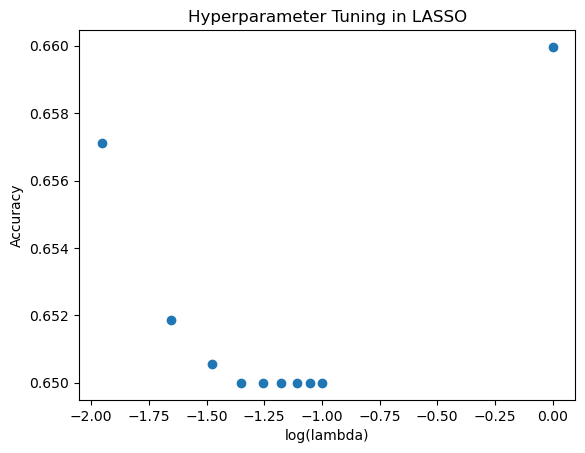

In [79]:
plt.scatter(log_lambda, cvModel_logreg_acc.avgMetrics)
plt.title('Hyperparameter Tuning in LASSO')
plt.xlabel('log(lambda)')
plt.ylabel('Accuracy')

## Conclusion

The goal of our project was to see if we would be able to predict a voters’ political party affiliation in the state of Georgia, based on the voter's education level, estimated household income, household composition, ethnicity, religious beliefs, primary language, and gender. As we stated in the introduction of our project, we chose Georgia because we felt as though it was a state that had a good mix of Democrats, Republicans, and Non-Partisan voters as well as having geography that was both rural and urban. After extensive exploratory data analysis we decided to create a multiclass model, binary models, and a lasso regression model. We felt as though these were the best models to choose because they function in different ways, yet they all work on roughly the same principles. After using a portion of our data set to train the models, we then used the remaining portion to test the data and see how each model performed. While it is hard to decisively say which model was the best overall because some models did better with certain classes, we will highlight the main findings from each of the models below:

Multiclass Model:

When it came to the multiclass model, we saw that it had the highest precision value for Democratic voters at 0.9390243902439024, which was significantly higher than the values we saw for Republican voters(0.6780354706684857) and Non-Partisan voters(0.6696362286562731). Based on our exploratory analysis of the data set this discrepancy can most likely be attributed to ethnicity or language. We found that certain ethnicities can be more heavily weighted when it comes to political parties, and some examples  of this are Europeans being predominantly Republican and African Americans being almost entirely Democrats. One thing that is very interesting to note when it comes to the significant predictors of both Democrats and Republicans is that language played a large role in choosing affiliation. This can be attributed to the fact that there may be a small portion of the population of Georgia that primarily speaks these languages(Hindi, Norwegian, German, etc.) and if a voter has this attribute then they tend to be affiliated with a specific party. Because of this fact, we realize that this model might not be the best when it comes to deciphering a generic profile of a voter that has attributes found in all three categories.

Binary Model: 
While it is important to look at the overall ROC AUC (for the training set it is 0.72 and for the testing set it is 0.73, so it is not overfitting and correctly classifying parties with moderate strength), but it is useful to look at statistics of specific classes instead of pooled data. We created One-vs-Rest binary classification models to split the multiclass dataset into binary sets to evaluate the varying ability to correctly classify political affiliations. For each binary model, we selected one specific class as the positive class and all others were regarded as the negative class. Using our feature values, our model is best at identifying patterns of Democrats with ROC AUC of about 0.89 while Non-Partisan and Republican voters have less often correcting classified and both have similar ROC AUC of about 0.82. Our selected predictors are better at predicting a subset (Democrats) than others, and it is worth noting that this is useful for when we are mainly focused on correctly identifying a certain group of people. 

Lasso Regression Model: 
We utilized a multiclass LASSO regularization logistic regression model using 5-fold cross validation. Our goal was to investigate the impact of unique patterns in the training data would have when predicting unseen data. LASSO penalizes insignificant and rare features and forces their weights to be zero. We created a grid of lambda values and used the metric to compare to our previous model without using penalties. Using a very small penalty term of log(0.01) = -2 does not significantly improve our ROC AUC or accuracy, and the metrics utilization penalties were also similar for both training and testing sets. 


When it comes to our project as a whole, we think that we were successful at being able to accurately predict the political party affiliation of a given voter. While we weren’t able to correctly predict every voter, this can mainly be attributed to the fact that in the real world political party affiliation is not necessarily determined by one characteristic or a group of characteristics, for there are members of different parties that share similar characteristics. Through this project we learned that while people may think that opposing political parties have nothing in common, there are similarities that may not be apparent at first.